# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

###### I have read and understood the instructions: 316352467 , 208508259

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x205a34feca0>, <__main__.Node at 0x205a34fedc0>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
#############################################################################
# TODO: Find the columns with missing values and remove them from the data.#
#############################################################################
data.dropna(axis='columns')
pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    #get all classes (from last row) and the amount of time they appear
    allClasses = np.array(np.unique(data[:,-1], return_counts=True)).T
    #number of classes in this dataset (number of uniqe values in last column)
    numberOfClasses = allClasses[:,0].size
    #size of the dataSet
    S = data[:,-1].size
    for c in range(numberOfClasses):
        gini += np.power(allClasses[c][1]/S,2)
    gini = 1-gini
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    #get all classes (from last row) and the amount of time they appear
    allClasses = np.array(np.unique(data[:,-1], return_counts=True)).T
    #number of classes in this dataset (number of uniqe values in last column)
    numberOfClasses = allClasses[:,0].size
    #size of the dataSet
    S = data[:,-1].size
    for c in range(numberOfClasses):
        entropy += (-1)*(allClasses[c][1]/S) * np.log2(allClasses[c][1]/S)
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [10]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [11]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    #if gain_ratio = true we need to calculate goodness_of_split with entropy
    if(gain_ratio):
        impurity_func = calc_entropy 
    
    #impurity of data
    dataImpurity = impurity_func(data)
    #size of data (|S|)
    S = data[:,-1].size
    #finding values of the feature and the amount of time each one appears
    allValues = np.array(np.unique(data[:,feature], return_counts=True)).T
    #number of values in this dataset (number of uniqe values in last column)
    numberOfValues = allValues[:,0].size
    tempSum = 0.0
    for v in range(numberOfValues):
        #creating dataSet with the current featur where the last column holds the labels
        featureAndClasses = data[:,[feature,-1]]
        #creating dataSet with the current value (value of featur : allValues[v][0])
        currentData = featureAndClasses[np.where(featureAndClasses[:,0] == allValues[v][0])]
        #calculation (|Sv|= allValues[v][1] this is the size of the current value)
        tempSum += (allValues[v][1]/S) * impurity_func(currentData)
    goodness = dataImpurity - tempSum
    
    #Gain Ratio calculation
    if(gain_ratio):
        informationGain = goodness  
        #calculate split information
        splitInformation = 0.0
        for a in range(numberOfValues):
            splitInformation += (-1) * (allValues[a][1]/S) * np.log2(allValues[a][1]/S)
        goodness = informationGain/splitInformation
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness    

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [12]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature):
        self.feature = feature # column index of criteria being tested
        self.children = []
        self.pred = {}
        self.parent = None
        self.currentValueOfFeature = ""
        
    def add_child(self, node):
        self.children.append(node)

In [13]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    maxGoodness = -1
    bestFeature = 0
    #check if data is perfectly classified or we reached max depth
    if (impurity(data) == 0 or max_depth == 0):
        leafNode = DecisionNode(-1)
        leafNode.pred = calculate_labels(data)
        return leafNode
    #find the best feature
    for featureIndex in range(data.shape[1] - 1):
        currentGoodness = goodness_of_split(data, featureIndex, impurity, gain_ratio)
        if (maxGoodness < currentGoodness):
            maxGoodness = currentGoodness
            bestFeature = featureIndex     
    #check if max_goodness which is the best_feature max_goodness is bigger then 0 (we can still split)
    if (maxGoodness > 0):
        #get all the unique values of this feature in an array
        rootValues = np.unique(data[:,bestFeature])
        #chi
        if chi < 1:
            chiVal = calcChiValue(data, bestFeature)
            if chiVal < chi_table[len(rootValues) - 1][chi]:
                leafNode = DecisionNode(-1,)
                leafNode.pred = calculate_labels(data) 
                return leafNode
        #creating node      
        root = DecisionNode(bestFeature)
        root.pred = calculate_labels(data)
        for currentVal in rootValues:
            #creating new data (that match to the current value of the feature - will be the data of the child)
            nextData = data[data[:, bestFeature] == currentVal]   
            #recurtion call
            childNode = build_tree(nextData, impurity, gain_ratio, chi, max_depth - 1)
            if (childNode != None):
                root.add_child(childNode)
                childNode.parent = root
                childNode.currentValueOfFeature = currentVal
    else:
        leafNode = DecisionNode(-1)
        leafNode.pred = calculate_labels(data) 
        return leafNode
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root


#help function that return a dictionary of unique values of labels and the amount they appear (example: {'e': 3154, 'p': 2939})
def calculate_labels(data):
    """
    return a dictionary of unique values of labels and the amount they appear
 
    Input:
    - datas: the dataset on which the calculation is preformed
 
    Output: the pred
    """
    labelsColumn = data[:, [data.shape[1] - 1]]
    labelsValues = np.unique(labelsColumn)
    labels = {}
    for currentLabel in labelsValues:
        labels[currentLabel] = np.count_nonzero(labelsColumn == currentLabel)
    return labels

In [14]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [15]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    while node.feature != -1:
        tempNode = None
        currentFeatureValue = instance[node.feature]
        for childNode in node.children:
            if childNode.currentValueOfFeature == currentFeatureValue:
                tempNode = childNode
                break
                
        if tempNode is None:
            break
        else:
            node = tempNode
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.pred

In [16]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for currInstance in dataset: 
        currentPredDictionary = predict(node, currInstance)
        if len(currentPredDictionary) == 0:
            continue
        if max(currentPredDictionary, key=currentPredDictionary.get) == currInstance[-1]:
            accuracy += 1
            
    accuracy /= dataset.shape[0]
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [17]:
#### Your code here ####
GiniTraining = calc_accuracy(tree_gini, X_train)
GiniTest = calc_accuracy(tree_gini, X_test)
EntropyTraining = calc_accuracy(tree_entropy, X_train)
EntropyTest = calc_accuracy(tree_entropy, X_test)
EntropyTrainingGainRatio = calc_accuracy(tree_entropy_gain_ratio, X_train)
EntropyTestGainRatio = calc_accuracy(tree_entropy_gain_ratio, X_test)

print("tree gini accuracy: for training set = {0} and for testing set = {1}".format(GiniTraining, GiniTest))
print("tree entropy accuracy: for training set = {0} and for testing set = {1}".format(EntropyTraining, EntropyTest))
print("tree entropy gain ratio: for training set = {0} and for testing set = {1}".format(EntropyTrainingGainRatio, EntropyTestGainRatio))

tree gini accuracy: for training set = 0.9924503528639422 and for testing set = 0.7749876907927129
tree entropy accuracy: for training set = 0.9940915805022157 and for testing set = 0.7725258493353028
tree entropy gain ratio: for training set = 0.9963892991957984 and for testing set = 0.7853274249138356


## Post pruning

Iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, create a plot of the training and testing accuracies as a function of the number of nodes in the tree. (15 points)

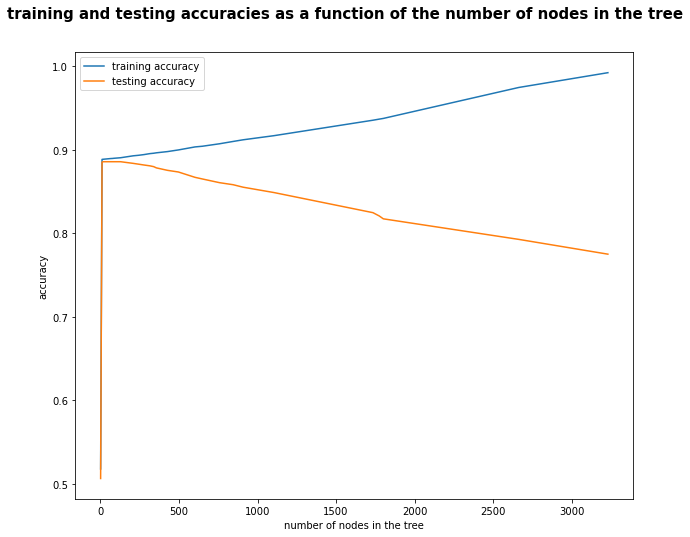

In [18]:
#### Your code here ####
#help function for decide which node to replace 
def post_pruning(root):
    """
    decide which node to replace
 
    Input:
    - root: a node in the decision tree.
    - data: the dataset on which the post pruning is evaluated
 
    Output:
    - accuracy: current accuracy of the tree after removing the node
    """  
    queue = []
    list_of_current_leafs = []
    queue.append(root)
    while(len(queue)):
        currentNode = queue.pop(0)
        if(currentNode.feature == -1):
            list_of_current_leafs.append(currentNode)
        for child in currentNode.children:
            queue.append(child)
    #iterate over all fathers and find the one that we want to replace with leaf and delete the leaf
    currentAccuracy = 0
    maxAccuracy = -1
    maxFather = None
    maxLeaf = None
    parents = []
    for leaf in list_of_current_leafs:
        if leaf.parent not in parents:
            parents.append(leaf.parent)
    for parent in parents:       
        parent_pred_temp = parent.pred
        #calculate the most popular class
        numberOfe = 0
        numberOfp = 0
        for child in parent.children:
            if 'e' in child.pred.keys():
                numberOfe += child.pred['e'] 
            if 'p' in child.pred.keys():
                numberOfp += child.pred['p']
        if(numberOfe > numberOfp):
            parent.pred = {'e':numberOfe}
        else:
            parent.pred = {'p': numberOfp}
        parent_children_temp = parent.children
        parent.children = []
        currentAccuracy = calc_accuracy(root,X_test)
        if (currentAccuracy > maxAccuracy):
            maxFather = parent
            maxAccuracy = currentAccuracy
        parent.pred = parent_pred_temp
        parent.children = parent_children_temp
    #replace father with a leaf using the popular class of the training data that reached that node
    numberOfe = 0
    numberOfp = 0
    for child in maxFather.children:
        if 'e' in child.pred.keys():
            numberOfe += child.pred['e'] 
        if 'p' in child.pred.keys():
            numberOfp += child.pred['p']
    if(numberOfe > numberOfp):
        maxFather.pred = {'e':numberOfe}
    if(numberOfe <= numberOfp):
        maxFather.pred = {'p': numberOfp}
    maxFather.children = []
    maxFather.feature = -1
    return calc_accuracy(root,X_train), calc_accuracy(root,X_test)

def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    result = 0
    queue = []
    queue.append(node)
    while(len(queue)):
        currentNode = queue.pop(0)
        result += 1
        for child in currentNode.children:
            queue.append(child)
    return result
    pass


#caculation
maxNumber = 0
maxAccuracy = 0
tree_gini_temp = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
accuracyOfTraining = []
accuracyOfTest = []
numberOfNodesInTheTree = []
#calculate the number of nodesn the tree and append it and the accuracy on the test set
numberOfNodesInTheTree.append(count_nodes(tree_gini_temp))
accuracyOfTraining.append(calc_accuracy(tree_gini_temp,X_train))
accuracyOfTest.append(calc_accuracy(tree_gini_temp,X_test))
while(count_nodes(tree_gini_temp) > 1):
    i,j = post_pruning(tree_gini_temp)
    accuracyOfTraining.append(i)
    accuracyOfTest.append(j)
    numberOfNodesInTheTree.append(count_nodes(tree_gini_temp))
    if (j>maxAccuracy):
        maxAccuracy = j
        maxNumber = count_nodes(tree_gini_temp)
#print the plot
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.9)
fig.suptitle('training and testing accuracies as a function of the number of nodes in the tree', fontsize=15, fontweight='bold')
plt.plot(numberOfNodesInTheTree, accuracyOfTraining)
plt.plot(numberOfNodesInTheTree, accuracyOfTest)
plt.xlabel("number of nodes in the tree")
plt.ylabel("accuracy")
plt.legend(['training accuracy', 'testing accuracy'])
plt.show()
pass

for instructor: it takes about 1-2 minutes to run the code

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle. (15 points)

In [19]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

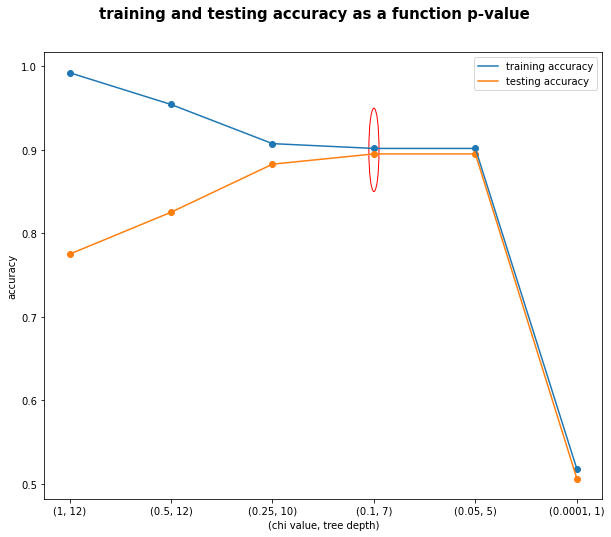

In [21]:
#### Your code here ####
#help function for chi square calculation
def calcChiValue(data, feature):
    """
    decide which node to replace
 
    Input:
    - data: the dataset
    - feature: the feature we calculate chi value
 
    Output:
    - chi_value: current chi
    """ 
    featureColumn = data[:, feature]
    nodeValues = np.unique(featureColumn)
    labelsDict = calculate_labels(data)
    labelsKeys = np.unique(data[:,-1])
    p0 = labelsDict[labelsKeys[0]] / len(data)
    p1 = labelsDict[labelsKeys[1]] / len(data)
    chiValue = 0
    for currentFeatureVal in nodeValues:
        df = np.count_nonzero(featureColumn == currentFeatureVal)
        E_0 = df * p0
        E_1 = df * p1
        pf = len(np.where((data[:,feature] ==  currentFeatureVal) & (data[:,-1] == labelsKeys[0]))[0])
        nf = len(np.where((data[:,feature] ==  currentFeatureVal) & (data[:,-1] == labelsKeys[1]))[0])
        chiValue += (np.square(pf - E_0) / E_0) + (np.square(nf - E_1) / E_1)
    return chiValue

#help function for depth calculation
def max_depth(node):
    """
    decide which node to replace
 
    Input:
    - root: a node in the decision tree.
 
    Output:
    - depth: depth of tree
    """  
    if not node.children:
        return 1
    return 1 + max(max_depth(child) for child in node.children)


#the chi test on different values
chiValues = [1, 0.5, 0.25, 0.1, 0.05, 0.0001]
GiniAccuracyTraining=[]
GiniAccuracyTest=[]
x_tuple = []
# currentDepth=[]
for i in chiValues:
    currentTree = build_tree(data=X_train, impurity=calc_gini, chi=i)
    GiniAccuracyTraining.append(calc_accuracy(currentTree, X_train))
    GiniAccuracyTest.append(calc_accuracy(currentTree, X_test))
    depth = max_depth(currentTree)
    x_tuple.append((i,depth))
#calculate best chi value
bestChi = x_tuple[np.argmax(GiniAccuracyTest,axis=0)]
#print the plot
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.9)
fig.suptitle('training and testing accuracy as a function p-value', fontsize=15, fontweight='bold')
plt.xlabel("(chi value, tree depth)")
plt.ylabel("accuracy")
plt.xticks(range(len(chiValues)),x_tuple)
plt.scatter(range(len(chiValues)),GiniAccuracyTraining)
plt.scatter(range(len(chiValues)),GiniAccuracyTest)
plt.plot(range(len(chiValues)),GiniAccuracyTraining)
plt.plot(range(len(chiValues)),GiniAccuracyTest)
plt.legend(['training accuracy', 'testing accuracy'])
circle2 = plt.Circle((3,0.9), 0.05, color='r', fill=False)
plt.gca().add_patch(circle2)
plt.show()


Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [22]:
#### Your code here ####
tree_chi = build_tree(data=X_train, impurity=calc_entropy,chi=bestChi[0] ,gain_ratio=True)
tree_post_pruning = build_tree(data=X_train, impurity=calc_gini)
while(count_nodes(tree_post_pruning) > maxNumber):
    post_pruning(tree_post_pruning)

print("tree_chi accuracy: for test set = {0}".format(calc_accuracy(tree_chi, X_test)))
print("tree_post_pruning accuracy: for test set = {0}".format(calc_accuracy(tree_post_pruning, X_test)))

tree_chi accuracy: for test set = 0.8951255539143279
tree_post_pruning accuracy: for test set = 0.8857705563761694


## Number of Nodes

Of the two trees above we will choose the one with fewer nodes. Complete the function counts_nodes and print the number of nodes in each tree. (5 points) 

In [23]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    result = 0
    queue = []
    queue.append(node)
    while(len(queue)):
        currentNode = queue.pop(0)
        result += 1
        for child in currentNode.children:
            queue.append(child)
    return result
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

#print number of nodes in each tree  
print("number of nodes in tree_chi: {0}".format(count_nodes(tree_chi)))
print("number of nodes in tree_post_pruning: {0}".format(count_nodes(tree_post_pruning)))

number of nodes in tree_chi: 55
number of nodes in tree_post_pruning: 128


## Print the tree

Complete the function `print_tree` and execute it on your chosen tree. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [24]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', _prefix="", _last=True):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    nameOfFeatures = list(data.columns)
    if(parent_feature=='ROOT'):
        print("[{0}, feature = {1}]".format(parent_feature,nameOfFeatures[node.feature]))
    elif (node.feature == -1):
        print(_prefix,"[{0}={1}, leaf] : ".format(nameOfFeatures[node.parent.feature], node.currentValueOfFeature), "[", node.pred, "]", sep="")
    else:
        print(_prefix,"[{0}={1}, feature = {2}]".format(nameOfFeatures[node.parent.feature],node.currentValueOfFeature,nameOfFeatures[node.feature]), sep="")     
    _prefix += "    " if _last else "    "
    child_count = len(node.children)
    for i, child in enumerate(node.children):
        _last = i == (child_count - 1)
        print_tree(child, 0, "", _prefix, _last)
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
#print the tree_chi (one with fewer nodes)
print_tree(tree_chi)

[ROOT, feature = odor]
    [odor=a, leaf] : [{'e': 273, 'p': 31}]
    [odor=c, leaf] : [{'e': 10, 'p': 137}]
    [odor=f, feature = stalk-surface-above-ring]
        [stalk-surface-above-ring=f, feature = cap-color]
            [cap-color=b, leaf] : [{'e': 8, 'p': 30}]
            [cap-color=g, leaf] : [{'e': 5, 'p': 26}]
            [cap-color=w, leaf] : [{'e': 1, 'p': 35}]
        [stalk-surface-above-ring=k, leaf] : [{'e': 134, 'p': 1037}]
        [stalk-surface-above-ring=s, leaf] : [{'e': 22, 'p': 310}]
    [odor=l, feature = cap-surface]
        [cap-surface=f, leaf] : [{'e': 19, 'p': 1}]
        [cap-surface=s, leaf] : [{'e': 94, 'p': 16}]
        [cap-surface=y, leaf] : [{'e': 159, 'p': 10}]
    [odor=m, leaf] : [{'e': 2, 'p': 25}]
    [odor=n, feature = gill-size]
        [gill-size=b, feature = spore-print-color]
            [spore-print-color=b, leaf] : [{'e': 34, 'p': 2}]
            [spore-print-color=k, leaf] : [{'e': 843, 'p': 93}]
            [spore-print-color=n, leaf]